# Data preprocessing

In [3]:
import pandas as pd
import jieba

content_and_label_path = '../content_and_label'
data = pd.read_msgpack(content_and_label_path)

# load in stopwords and define passage segmentation function
stopwords = []
stopwords_path = '../stop_words.txt'
with open(stopwords_path, 'rb') as f:
    stopwords = f.read().decode('gbk').splitlines()

import re
# after segmentation, converting to pinyin and ignore speical symbols
def passageSeg(passage):
    ''' 
    Remove stopwords and \\n s, make segementation
    Args: 
        passage: a string of single passage
    Return: 
        a string of segmentation
    '''
    clean = []
    passage = re.sub(r"http\S+", "", passage)
    passage = passage.strip('\n').replace('\n', '').replace(' ','')
    words = jieba.cut(passage, cut_all=False)
    for word in words:
        if word not in stopwords:
             clean.append(word)   
    return ' '.join(clean)        


In [4]:
data = data.dropna(subset=['content'])

data['cleanedContent'] = data['content'].apply(passageSeg)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/xf/z6j0j5z500g7k_ygjj7mr2xh0000gn/T/jieba.cache
Loading model cost 1.047 seconds.
Prefix dict has been built succesfully.


# Create embedding matrix

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPool1D, Embedding
from keras.models import Model
from keras import regularizers

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
embedding_dir = "../result/filv3.vec"

texts = data['cleanedContent'].tolist()

labels = data['zixun'].tolist()

print('Found {0} texts and {1} labels'.format(len(texts), len(labels)))

import numpy as np
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

afterPadding = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', afterPadding.shape)
print('Shape of label tensor:', labels.shape)

# shuffle the data and split it into train and test datasets
indices = np.arange(afterPadding.shape[0])
np.random.shuffle(indices)
afterPadding = afterPadding[indices]
labels = labels[indices]
nb_val = int(VALIDATION_SPLIT * data.shape[0])
x_train = afterPadding[:-nb_val]
x_val = afterPadding[-nb_val:]
y_train = labels[:-nb_val]
y_val = labels[-nb_val:]

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

# load in pre-trained word embedding
from itertools import islice
embeddings_index = {}
with open(embedding_dir) as f:
    next(f)
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
print('Number of word vectors is %s' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

# link embedding to wordindex, create embedding matrix
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 3565 texts and 3565 labels
Shape of data tensor: (3565, 1000)
Shape of label tensor: (3565, 2)
(3209, 1000) (356, 1000) (3209, 2) (356, 2)
Number of word vectors is 221000


# Build model

In [6]:
# building embedding_layer
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True);

In [7]:
# define own metrics: precision recall and f1
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

# Model 1: with different conv windows

from keras.models import Sequential
from keras.layers import Activation, GlobalMaxPool1D, Merge, concatenate
from keras.callbacks import EarlyStopping

submodels = []
for kw in (3, 4, 5):    # kernel sizes
    submodel = Sequential()
    submodel.add(Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable=False))
    submodel.add(Conv1D(32,
                        kw,
                        padding='valid',
                        activation='relu',
                        strides=1))
    submodel.add(Conv1D(32,
                        kw,
                        padding='valid',
                        activation='relu',
                        strides=1))
    
    submodel.add(GlobalMaxPool1D())
    submodels.append(submodel)
big_model = Sequential()
big_model.add(Merge(submodels, mode="concat"))
big_model.add(Dense(64))

big_model.add(Activation('relu'))
big_model.add(Dropout(0.5))
big_model.add(Dense(labels.shape[1]))
big_model.add(Activation('softmax'))
print('Compiling model')
big_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

big_model.summary()

hist = big_model.fit([x_train, x_train, x_train],
                     y_train,
                     batch_size=50,
                     epochs=10,
                     validation_data=([x_val, x_val, x_val], y_val),
                     callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=2)]
                     )

/Users/zijiaoyang/anacon/anaconda/envs/easynn/lib/python3.6/site-packages/ipykernel/__main__.py:62: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Compiling model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6208      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 116,219,618
Trainable params: 134,018
Non-trainable params: 116,085,600
________________________________________

KeyboardInterrupt: 

# model 2: unique window size

In [ ]:
# building embedding_layer
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequences_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequences_input)
x = Conv1D(32, 3, activation='relu')(embedded_sequences)
#x = MaxPool1D(5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = MaxPool1D(5)(x)
x = Conv1D(16, 3, activation='relu')(x)
#x = MaxPool1D(35)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
#x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(labels.shape[1], activation='softmax')(x)

model = Model(sequences_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
#early_stopping = Ear

model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=50)

big_model.summary()

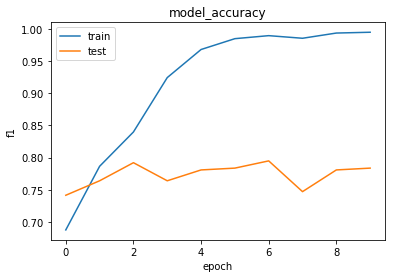

In [34]:
# Print train_acc and val_acc
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model_accuracy')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [177]:
# random guess precision
np.sum(labels, axis=0)/labels.shape[0]

array([ 0.65021038,  0.34978962])

In [361]:
from sklearn.metrics import confusion_matrix
prediction = big_model.predict([x_val,x_val,x_val])

r = []
for i, j in prediction:
    p = [1,0] if i> 0.5 else [0,1]
    r.append(p)



val = [j for _, j in y_val]
pr = [j for _, j in r]

confusion_matrix(val, pr)

prec = 65/91

recall = 65/110

In [2]:
print("prec is {0:5f}, recall is {1:5f} ".format(prec, recall))

NameError: name 'prec' is not defined

## Char level one

In [8]:
MAX_SEQUENCE_LENGTH = 1000
VALIDATION_SPLIT = 0.2

In [11]:
cd ../

/Users/zijiaoyang/Desktop/junlin


In [14]:
import pandas as pd
import jieba
content_and_label_path = './content_and_label'
data = pd.read_msgpack(content_and_label_path)

# load in stopwords and define passage segmentation function
stopwords = []
stopwords_path = './cnnfornlp/stop_words.txt'
with open(stopwords_path, 'rb') as f:
    stopwords = f.read().decode('gbk').splitlines()

import re
# after segmentation, converting to pinyin and ignore speical symbols
def passageSeg(passage):
    ''' 
    Remove stopwords and \\n s, make segementation
    Args: 
        passage: a string of single passage
    Return: 
        a string of segmentation
    '''
    clean = []
    passage = re.sub(r"http\S+", "", passage)
    passage = passage.strip('\n').replace('\n', '').replace(' ','')
    words = jieba.cut(passage, cut_all=False)
    for word in words:
        if word not in stopwords:
             clean.append(word)   
    return ' '.join(clean)        


In [15]:
data = data.dropna(subset=['content'])

data['cleanedContent'] = data['content'].apply(passageSeg)

In [8]:
texts = data['cleanedContent'].tolist()

labels = data['zixun'].tolist()

print('Found {0} texts and {1} labels'.format(len(texts), len(labels)))

Found 3565 texts and 3565 labels


In [9]:
result = [(a,b) for a, b in zip(texts, labels) if a != '']
ttext, tlabels = map(list, zip(*result))

In [10]:
ttext, tlabels = [list(x) for x in zip(*result)]

In [11]:
import pypinyin
from functools import reduce

def conv2pinyin(texts):
    pinyin_text = []
    abnormal = []
    for i in range(len(texts)):
        text = pypinyin.pinyin(texts[i], style=pypinyin.TONE3)
        try:
            text = reduce(lambda x,y: x+y, text)
            text = ''.join(text)
        except:
            abnormal.append(i)
            continue
        pinyin_text.append(text)
    return pinyin_text, abnormal

def re(fun, lst):
    if len(lst) == 1 :
        return lst[0]
    if lst == []:
        return False
    return fun(lst[0], re(fun, lst[1:]))

import numpy as np

all_letters = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}\n"

n_letters = len(all_letters)

      
def letterToIndex(letter):
    """
    'c' -> 2
    """
    return all_letters.find(letter)


def sets2tensors(clean_train, n_letters=n_letters, MAX_SEQUENCE_LENGTH=1000):
    """
    From lists of cleaned passages to np.array with shape(len(train), 
        max_sequence_length, len(dict))
    Arg: 
        obviously
    """
    m = len(clean_train)
    x_data = np.zeros((m, MAX_SEQUENCE_LENGTH, n_letters))
    for ix in range(m):
        for no, letter in enumerate(clean_train[ix]):
            if no >= 1000:
                break
            letter_index = letterToIndex(letter)
            if letter != -1:
                x_data[ix][no][letter_index]  = 1
            else:
                continue            
    return x_data

def to_cat(labels, num_class, start):
    """
    Convert a categorical label to a vector : 4 -> [0, 0,0,1]
    """
    labels = [[1 if i == l else 0 for i in range(start, num_class+start)] for l in labels]
    return np.array(labels)

In [14]:
test_texts, abn = conv2pinyin(ttext)

In [15]:
import numpy as np

labels = to_cat(tlabels, 2, 0)
#texts = conv2pinyin(texts)
texts = sets2tensors(test_texts)
print('Shape of data tensor:', texts.shape)
print('Shape of label tensor:', labels.shape)

# shuffle the data and split it into train and test datasets
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts = texts[indices]
labels = labels[indices]
nb_val = int(VALIDATION_SPLIT * texts.shape[0])
x_train = texts[:-nb_val]
x_val = texts[-nb_val:]
y_train = labels[:-nb_val]
y_val = labels[-nb_val:]

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

Shape of data tensor: (3560, 1000, 70)
Shape of label tensor: (3560, 2)
(2848, 1000, 70) (712, 1000, 70) (2848, 2) (712, 2)


In [16]:
%reload_ext autoreload
%autoreload -l

In [17]:
## Model 
num_classes = 2
n_letters = 70
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Activation, GlobalMaxPool1D, Conv1D, Dense, Dropout
from keras.callbacks import EarlyStopping, History
from keras.optimizers import SGD
from keras.layers import concatenate
submodels = []
inputs = []
for kw in (3, 4, 5):    # kernel sizes
    input1 = Input(shape=(1000, n_letters))
    inputs.append(input1)
    input1 = Conv1D(32, kw, padding='valid', activation='relu',
                    strides=1)(input1)
    
    input1 = GlobalMaxPool1D()(input1)
    submodels.append(input1)
    
    
model = concatenate(submodels)
#big_model.add(Merge(submodels, mode="concat"))
model = Dense(64, activation='relu')(model)
model = Dropout(0.5)(model)
output = Dense(num_classes, activation='softmax')(model)
model = Model(inputs, output)
print('Compiling model')
#opt = SGD(lr=1e-3)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Compiling model


In [18]:
history = History()
model.fit([x_train] * 3,
                     y_train,
                     batch_size=1,
                     epochs=5,
                     validation_data=([x_val] * 3, y_val),
                     callbacks=[history, EarlyStopping(monitor='val_loss', mode='min', patience=2)]
                     )

Train on 2848 samples, validate on 712 samples
Epoch 1/5
2848/2848 [==============================] - 26s - loss: 0.6598 - acc: 0.6440 - val_loss: 0.6511 - val_acc: 0.6362

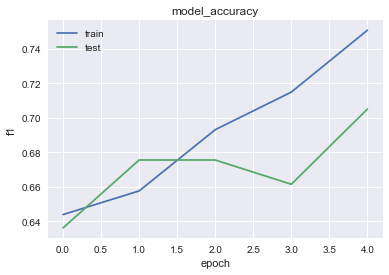

In [21]:
# Print train_acc and val_acc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model_accuracy')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()